In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize
import scipy.signal as signal

from datetime import datetime
import pytz

import gm2
import trfp
import helper_function_candidates as helper
import plotting_functions as plt2

In [4]:
run = 4141

# import the run and drop any freqencies that are associated with a DQC flag

run4141 = gm2.FixedProbe([4141], prefix='dev/FieldPlainRootOutput_')

fp_time, fp_freq, fp_qual = run4141.getBasics()
fp_time = fp_time[1:,:]/1.0e9  # drop the first even of the run
fp_freq = fp_freq[1:,:]
fp_qual = fp_qual[1:,:]

fp_qual[fp_qual >= 2**16] -= 2**16
fp_qual[fp_qual >= 2**8] -= 2**8

fp_freq[fp_qual > 0] = np.nan

Reading event 4360/4367 99.84%     
loop done: 100%                                    


In [7]:
# do the interpolation using the integration method

times = np.arange(np.ceil(fp_time[0, 377]),
                  np.floor(fp_time[-1, 0]) + 1,
                  1)  # NOTE THIS IS 1 SECOND NOW, DOESN'T MATTER BECAUSE OF INTEGRATION METHOD

fp_freq_interp = np.empty([times.size, 378])

steps = 100
rate = 1./steps
offset = steps/2

integration_times = np.arange(times[0], times[-1], rate)
not_nan = ~np.isnan(fp_freq)

for probe in range(378):
    integration_points = np.interp(integration_times, fp_time[:,probe][not_nan[:,probe]], fp_freq[:,probe][not_nan[:,probe]])

    cumulative_integration = scipy.integrate.cumtrapz(integration_points, integration_times,
                                                     initial=0) + integration_points[0]

    indices = [steps*i + offset for i in range(integration_times.size/steps)]

    output = np.diff(cumulative_integration[indices])
    output = np.append(np.array([integration_points[0]]), output)
    output = np.append(output, np.array([integration_points[-1]]))

    fp_freq_interp[:,probe] = output

In [108]:
# filter the "noisy" stations using 1st order Butterworth filter with characteristic time 200
tau = 300.
interp = fp_freq_interp.copy()

noisy_probes = [3,4,5,9,10,11,15,16,17,21,22,23,27,28,33,34,35,
                74,75,124,221,257,332,341,342,372]

b, a = signal.butter(1,1./tau)

# for probe in noisy_probes:
#     interp[:,probe] = signal.filtfilt(b, a, interp[:,probe], method='gust')

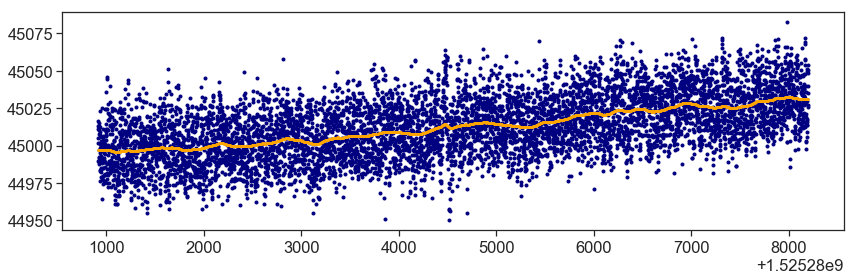

In [104]:
fig, ax = plt.subplots(1,1)

pr = 9

plt.plot(times, fp_freq_interp[:,pr], '.', color='navy')
plt.plot(times, interp[:,pr], '.', color='orange', markersize=2)

fig.set_size_inches(12,4)
fig.tight_layout()

In [109]:
# build interp dataframe

cols = ["fp" + str(i) for i in np.arange(378)]
interp_df = pd.DataFrame(interp, index=times, columns=cols)

#build moment df

moment_df = pd.DataFrame(index=interp_df.index)

for station in np.arange(72):
    print '\rCalculating station ' + str(station) + ' moments.',
    fp_st = ['fp'+str(fp) for fp in trfp.STATION_PROBE_ID[station]]

    # choose proper theta matrix
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        if station == 41:
            theta_fp = trfp.THETA_FP_4_ST41
        elif (station == 37) | (station == 39):
            theta_fp = trfp.THETA_FP_4_ST37_ST39
        else:
            theta_fp = trfp.THETA_FP_4
    else:
        theta_fp = trfp.THETA_FP_6

    # step through m values
    for m in np.arange(len(trfp.STATION_PROBE_ID[station])):
        stm = 'st'+str(station)+',m'+str(m+1)
        moment_df[stm] = interp_df[fp_st].dot(theta_fp[m])
    if len(trfp.STATION_PROBE_ID[station]) == 4:
        moment_df['st'+str(station)+',m5'] = np.nan
        moment_df['st'+str(station)+',m6'] = np.nan

Calculating station 71 moments.  


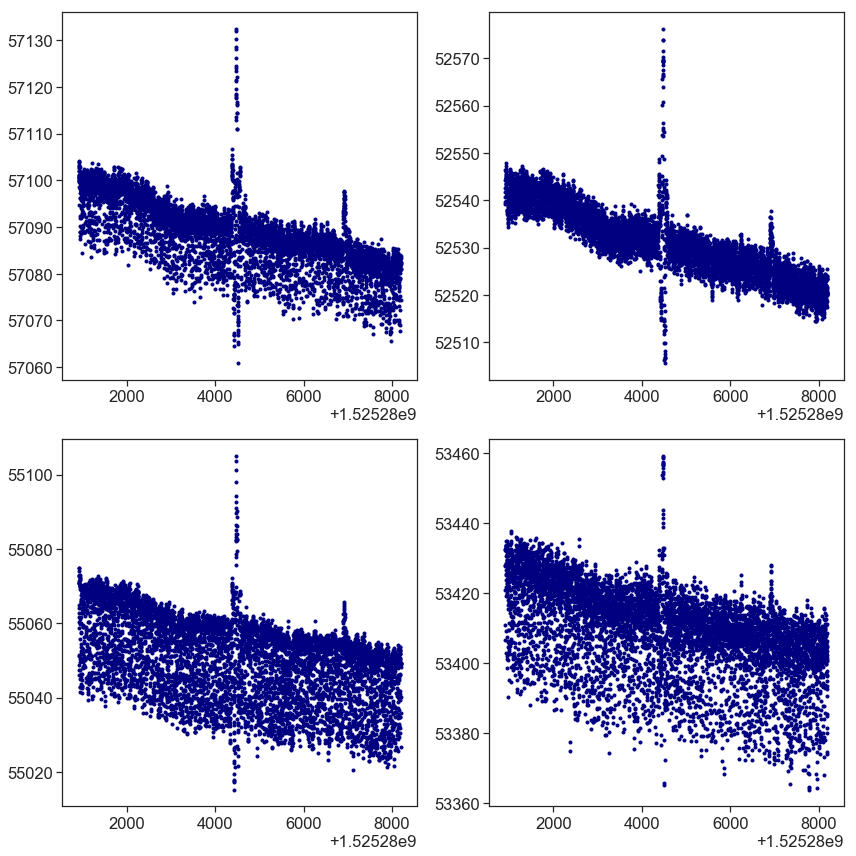

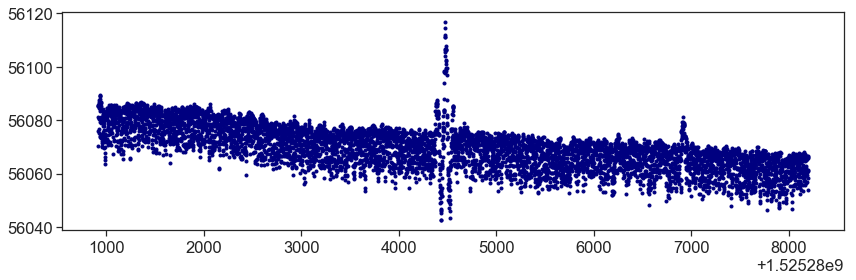

In [110]:
st = 63

pr_id = trfp.STATION_PROBE_ID[st]

figs, axs = plt.subplots(len(pr_id)/2,2)
for i in range(len(pr_id)):
    plt.sca(axs[i//2,i%2])
    plt.plot(interp_df.index.values, interp_df['fp'+str(pr_id[i])], '.', color='navy')
figs.set_size_inches(12,12)
figs.tight_layout()

fig, ax = plt.subplots(1,1)

pr = 9

plt.plot(moment_df.index.values, moment_df['st'+str(st)+',m1'], '.', color='navy')

fig.set_size_inches(12,4)
fig.tight_layout()

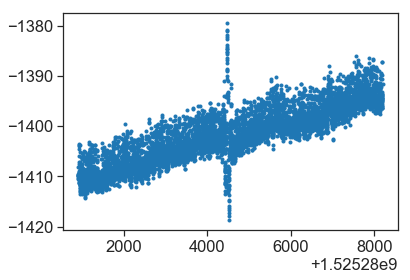

In [111]:
fig,ax = plt.subplots(1,1)

plt.plot(moment_df['st69,m1']-filtered, '.')

In [107]:
filtered = moment_df['st63,m1'].values